In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from numpy.random import seed
from utils import *
from model import lstm

Using TensorFlow backend.


Set up

In [2]:
seed(1)
tf.random.set_seed(1)

n_timestamp = 1
n_epochs = 50
# ====================================
#      model type：
#            1. single-layer LSTM
#            2. multi-layer LSTM
#            3. bidirectional LSTM
# ====================================
model_type = 3

Load data

In [3]:


yuan_data = pd.read_csv('./vgi2.csv')  # date, close, open, high, low, nmVolume
yuan_data.index = pd.to_datetime(yuan_data['date'], format='%Y-%m-%d') 
yuan_data = yuan_data.drop('date', axis=1)

In [4]:
yuan_data 

,close,open,high,low,nmVolume
date,,,,,
2018-09-25,21.0,21.0,21.0,16.0,1816800.0
2018-09-26,23.9,23.9,23.9,23.8,214200.0
2018-09-27,27.4,27.4,27.4,27.4,388100.0
2018-09-28,28.2,31.5,31.5,27.4,2111074.0
2018-10-01,26.8,29.5,29.6,25.8,831097.0
...,...,...,...,...,...
2021-12-27,32.4,31.7,32.8,31.7,289274.0
2021-12-28,31.9,32.4,32.8,31.8,235860.0
2021-12-29,31.8,32.0,32.0,31.6,243603.0


Split Train - Validation - Test set

In [5]:
# train # 2018-09-25 --> 2020-11-24
# valid # 2020-11-25 --> 2021-10-29
# test_set #2021-11-01 --> 2021-12-31
yuan_train = yuan_data[yuan_data.index <= '2020-11-24']
yuan_valid = yuan_data[(yuan_data.index <= '2021-10-29')&(yuan_data.index > '2020-11-24')]
yuan_test_set = yuan_data[(yuan_data.index <= '2021-12-31')&(yuan_data.index > '2021-10-29')]
print('train shape:', yuan_train.shape)
print('validation shape:', yuan_valid.shape)
print('test shape:', yuan_test_set.shape)


train shape: (566, 5)
validation shape: (243, 5)
test shape: (45, 5)


In [6]:
yuan_training_set = pd.concat([yuan_train, yuan_valid], axis=0)
yuan_training_set

,close,open,high,low,nmVolume
date,,,,,
2018-09-25,21.0,21.0,21.0,16.0,1816800.0
2018-09-26,23.9,23.9,23.9,23.8,214200.0
2018-09-27,27.4,27.4,27.4,27.4,388100.0
2018-09-28,28.2,31.5,31.5,27.4,2111074.0
2018-10-01,26.8,29.5,29.6,25.8,831097.0
...,...,...,...,...,...
2021-10-25,36.9,37.9,37.9,36.7,533523.0
2021-10-26,37.4,36.9,37.8,36.6,727721.0
2021-10-27,37.5,37.4,37.9,37.3,752737.0


Min Max Scaler

In [7]:
yuan_sc = MinMaxScaler(feature_range=(0, 1))
yuan_train_scaled = yuan_sc.fit_transform(yuan_train)
yuan_valid_scaled = yuan_sc.transform(yuan_valid)
yuan_testing_set_scaled = yuan_sc.transform(yuan_test_set)

In [8]:
yuan_X_train, yuan_y_train = data_split(yuan_train_scaled, n_timestamp)
yuan_X_train = yuan_X_train.reshape(yuan_X_train.shape[0], yuan_X_train.shape[1], 5)
yuan_X_train.shape

(565, 1, 5)

In [9]:
yuan_X_valid, yuan_y_valid = data_split(yuan_valid_scaled, n_timestamp)
yuna_X_valid = yuan_X_valid.reshape(yuan_X_valid.shape[0], yuan_X_valid.shape[1], 5)
yuan_X_valid.shape

(242, 1, 5)

In [10]:
yuan_X_test, yuan_y_test = data_split(yuan_testing_set_scaled, n_timestamp)
yuna_X_test = yuan_X_test.reshape(yuan_X_test.shape[0], yuan_X_test.shape[1], 5)
yuan_X_test.shape

(44, 1, 5)

LSTM model with three type: Single layer, Multiple layer, Bidirectional 

In [29]:
from keras.layers import Dropout
def lstm(model_type, yuan_X_train):
    # if model_type == 1:
    #     # single-layer LSTM
       
    #     yuan_model = Sequential()
    #     yuan_model.add(LSTM(units=50, activation='relu',
    #                 input_shape=(yuan_X_train.shape[1], 5)))
    #     yuan_model.add(Dense(units=5))
    if model_type == 1:
        # single-layer LSTM
       
        yuan_model = Sequential()
        yuan_model.add(LSTM(units=128, activation='relu',
                    input_shape=(yuan_X_train.shape[1], 5)))
        yuan_model.add(Dropout(0.2))
        yuan_model.add(Dense(units=128))
        yuan_model.add(Dropout(0.2))
        yuan_model.add(Dense(units=5))

    # if model_type == 2:
    #     # multi-layer LSTM
        
    #     yuan_model = Sequential()
    #     yuan_model.add(LSTM(units=50, activation='relu', return_sequences=True,
    #                 input_shape=(yuan_X_train.shape[1], 5)))
    #     yuan_model.add(LSTM(units=50, activation='relu'))
    #     yuan_model.add(Dense(5))
    if model_type == 2:
        # multi-layer LSTM
        
        yuan_model = Sequential()
        yuan_model.add(LSTM(units=50, activation='relu', return_sequences=True,
                    input_shape=(yuan_X_train.shape[1], 5)))
        yuan_model.add(Dropout(0.2))
        yuan_model.add(LSTM(units=50, activation='relu'))
        yuan_model.add(Dropout(0.2))
        yuan_model.add(Dense(5))
    if model_type == 3:
        # BiLSTM
       
        yuan_model = Sequential()
        yuan_model.add(Bidirectional(LSTM(50, activation='relu'),
                                    input_shape=(yuan_X_train.shape[1], 5)))
        yuan_model.add(Dense(5))

    return yuan_model

LSTM Model

In [30]:
model_type = 1
yuan_model = lstm(model_type, yuan_X_train)
print(yuan_model.summary())
adam = Adam(learning_rate=0.01)

yuan_model.compile(optimizer=adam,
                   loss='mse')

yuan_history = yuan_model.fit(yuan_X_train, yuan_y_train,
                              batch_size=32,
                              epochs=n_epochs,
                              validation_data=(yuan_X_valid, yuan_y_valid),
                              validation_freq=1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               68608     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 645       
Total params: 85,765
Trainable params: 85,765
Non-trainable params: 0
_________________________________________________________________
None
Train on 565 samples, validate on 242 samples
Epoch 1/50
565/565 [==============================] - 1s 2ms/step

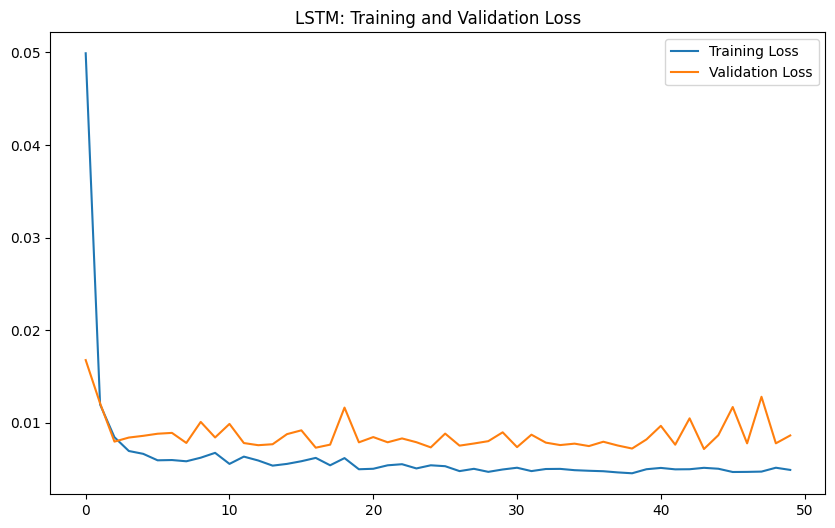

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(yuan_history.history['loss'], label='Training Loss')
plt.plot(yuan_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM: Training and Validation Loss')
plt.legend()
plt.show()

Save LSTM Model

In [32]:
# Save the model architecture to a JSON file
model_architecture = yuan_model.to_json()
with open('model_architecture.json', 'w') as json_file:
    json_file.write(model_architecture)

# Save the model weights to an HDF5 file
yuan_model.save_weights('./LSTM_model.h5')

Load LSTM Model

In [33]:

# Load the model architecture from the JSON file
with open('model_architecture.json', 'r') as json_file:
    loaded_model_architecture = json_file.read()

# Create a new model from the loaded architecture
loaded_model = tf.keras.models.model_from_json(loaded_model_architecture)

# Load the saved weights into the model
loaded_model.load_weights('LSTM_model.h5')

# Compile the loaded model
loaded_model.compile(optimizer=adam, loss='mse')

LSTM Prediction

In [34]:
# Now the loaded model is ready for prediction
predictions = loaded_model.predict(yuan_X_test)
# Print the predictions
print(predictions)

[[1.055003   1.0616486  1.021147   1.0337832  0.4934516 ]
 [1.0611389  1.0638479  1.028691   1.0349494  0.5405726 ]
 [1.022521   1.0256349  0.9904458  0.99837685 0.50977874]
 [1.0007583  1.0110745  0.9653426  0.9864763  0.39951506]
 [1.0017943  1.012795   0.9659651  0.98813987 0.3906215 ]
 [0.9998543  1.0076624  0.9661537  0.98269737 0.43932778]
 [0.99585736 1.0050994  0.96122485 0.98051417 0.41346458]
 [0.98626864 0.99692225 0.95081043 0.97291434 0.38419837]
 [0.9830668  0.9842416  0.9522541  0.95849764 0.50299156]
 [0.9588424  0.9628241  0.927296   0.9389385  0.45502818]
 [0.96795475 0.97770345 0.93311495 0.9545884  0.38031173]
 [0.95848703 0.9699906  0.92275476 0.9473375  0.34942883]
 [1.0099883  1.0120627  0.97847176 0.9855523  0.51068753]
 [0.9893534  0.9985367  0.9548303  0.9742143  0.40926188]
 [0.94357014 0.950367   0.9113178  0.9276166  0.41383037]
 [0.8763604  0.87917805 0.84651667 0.85832787 0.41108793]
 [0.8646159  0.87069464 0.83315027 0.85174394 0.35623002]
 [0.8804724  0

Inverse Min Max Scale

In [35]:
yuan_predicted_stock_price = yuan_sc.inverse_transform(predictions)
yuan_predicted_stock_price_list = np.array(yuan_predicted_stock_price[:, 0]).flatten().tolist() # 0 means close predicted value
yuan_predicted_stock_price1 = {
    'date': yuan_test_set.index[1:], # Passing first 1 time step
    'close': yuan_predicted_stock_price_list
}
yuan_predicted_stock_price1 = pd.DataFrame(yuan_predicted_stock_price1)
yuan_predicted_stock_price1 = yuan_predicted_stock_price1.set_index(['date'], drop=True)
yuan_predicted_stock_price1

,close
date,
2021-11-02,39.113579
2021-11-03,39.271271
2021-11-04,38.278790
2021-11-05,37.719490
2021-11-08,37.746117
2021-11-09,37.696259
2021-11-10,37.593536
2021-11-11,37.347103
2021-11-12,37.264816


In [36]:
yuan_real_stock_price = yuan_sc.inverse_transform(yuan_y_test)
yuan_real_stock_price_list = np.array(yuan_real_stock_price[:, 0]).flatten().tolist()
yuan_real_stock_price1 = {
    'date': yuan_test_set.index[1:],
    'close': yuan_real_stock_price_list
}
yuan_real_stock_price1 = pd.DataFrame(yuan_real_stock_price1)
yuan_real_stock_price1 = yuan_real_stock_price1.set_index(['date'], drop=True)
yuan_real_stock_price1

,close
date,
2021-11-02,38.8
2021-11-03,37.5
2021-11-04,37.9
2021-11-05,37.7
2021-11-08,37.7
2021-11-09,37.6
2021-11-10,37.3
2021-11-11,36.6
2021-11-12,36.4


In [37]:
# evaluation_metric(y_test,y_hat):
evaluation_metric(yuan_real_stock_price1['close'], yuan_predicted_stock_price1['close'])
# n_timestamp = 10, Bi
# MSE: 0.63082
# RMSE: 0.79424
# MAE: 0.61791
# R2: 0.79118

# n_timestamp = 1, Bi
# MSE: 0.53394
# RMSE: 0.73071
# MAE: 0.55920
# R2: 0.89246

# n_timestamp = 1, SL
# MSE: 0.50653
# RMSE: 0.71171
# MAE: 0.50775
# R2: 0.89798

# n_timestamp = 1, SL, 128, dropout 0.2
# MSE: 0.53411
# RMSE: 0.73083
# MAE: 0.57400
# R2: 0.89243

# n_timestamp = 1, ML
# MSE: 0.71405
# RMSE: 0.84501
# MAE: 0.62181
# R2: 0.85618

MSE: 0.58105
RMSE: 0.76227
MAE: 0.52909
R2: 0.88297


In [38]:
# GetMAPE(y_hat, y_test):
mape_LSTM_test = GetMAPE(yuan_predicted_stock_price1['close'], yuan_real_stock_price1['close'])
print('mape_LSTM_test : %.3f' % mape_LSTM_test, '%' )
# n_timestamp = 10. Bi
# mape_LSTM : 1.827 %

# n_timestamp = 1, Bi
# mape_LSTM_test : 1.626 %

# n_timestamp = 1, SL
# mape_LSTM_test : 1.488 %

# n_timestamp = 1, SL, 128, dropout 0.2
# mape_LSTM_test : 1.658 %

# n_timestamp = 1, ML
# mape_LSTM_test : 1.808 %

mape_LSTM_test : 1.539 %


d:\Software\Anaconda\envs\penguin\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


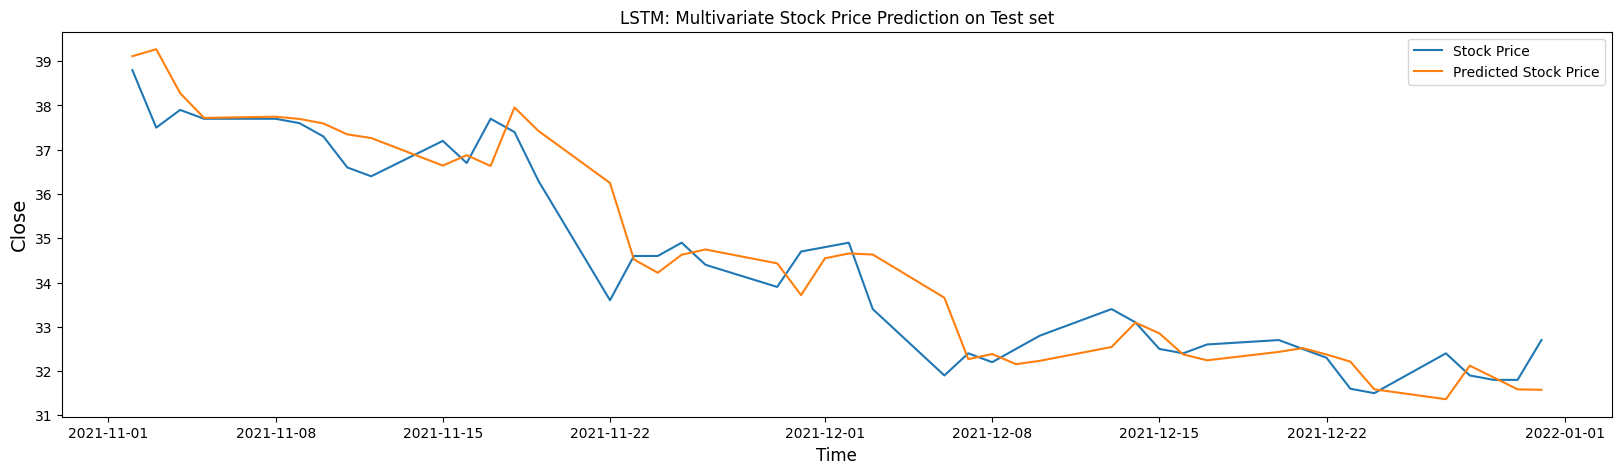

In [39]:
plt.figure(figsize=(20, 5))
plt.plot(yuan_real_stock_price1['close'], label='Stock Price')
plt.plot(yuan_predicted_stock_price1['close'], label='Predicted Stock Price')
plt.title('LSTM: Multivariate Stock Price Prediction on Test set')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

In [42]:
# Now the loaded model is ready for prediction
predictions_validation = loaded_model.predict(yuna_X_valid)
predictions_validation  = yuan_sc.inverse_transform(predictions_validation)
predictions_validation_list = np.array(predictions_validation[:, 0]).flatten().tolist() # 0 means close predicted value
predictions_validation_df = {
    'date': yuan_valid.index[1:], # Passing first 1 time step
    'close': predictions_validation_list
}
predictions_validation_df = pd.DataFrame(predictions_validation_df)
predictions_validation_df = predictions_validation_df.set_index(['date'], drop=True)


real_validation = yuan_sc.inverse_transform(yuan_y_valid)
real_validation_list = np.array(real_validation[:, 0]).flatten().tolist()
real_validation_df = {
    'date': yuan_valid.index[1:],
    'close': real_validation_list
}
real_validation_df = pd.DataFrame(real_validation_df)
real_validation_df = real_validation_df.set_index(['date'], drop=True)

In [43]:
# evaluation_metric(y_test,y_hat):
evaluation_metric(real_validation_df['close'], predictions_validation_df['close'])

# GetMAPE(y_hat, y_test):
mape_LSTM_validation = GetMAPE(predictions_validation_df['close'], real_validation_df['close'])
print('mape_LSTM_validation : %.3f' % mape_LSTM_validation, '%' )
# n_timestamp = 10, Bi
# MSE: 1.62542
# RMSE: 1.27492
# MAE: 0.93958
# R2: 0.91737
# mape_LSTM_validation : 2.580 %

# n_timestamp = 1, Bi
# MSE: 1.36230
# RMSE: 1.16718
# MAE: 0.82153
# R2: 0.92988
# mape_LSTM_validation : 2.297 %

# n_timestamp = 1, SL
# MSE: 1.31022
# RMSE: 1.14465
# MAE: 0.80925
# R2: 0.93256
# mape_LSTM_validation : 2.255 %

# n_timestamp = 1, SL, 128, dropout 0.2
# MSE: 1.58071
# RMSE: 1.25726
# MAE: 0.88581
# R2: 0.91864
# mape_LSTM_validation : 2.434 %

# n_timestamp = 1, ML
# MSE: 1.47587
# RMSE: 1.21485
# MAE: 0.86631
# R2: 0.92403
# mape_LSTM_validation : 2.414 %

MSE: 1.21082
RMSE: 1.10037
MAE: 0.77008
R2: 0.93768
mape_LSTM_validation : 2.178 %


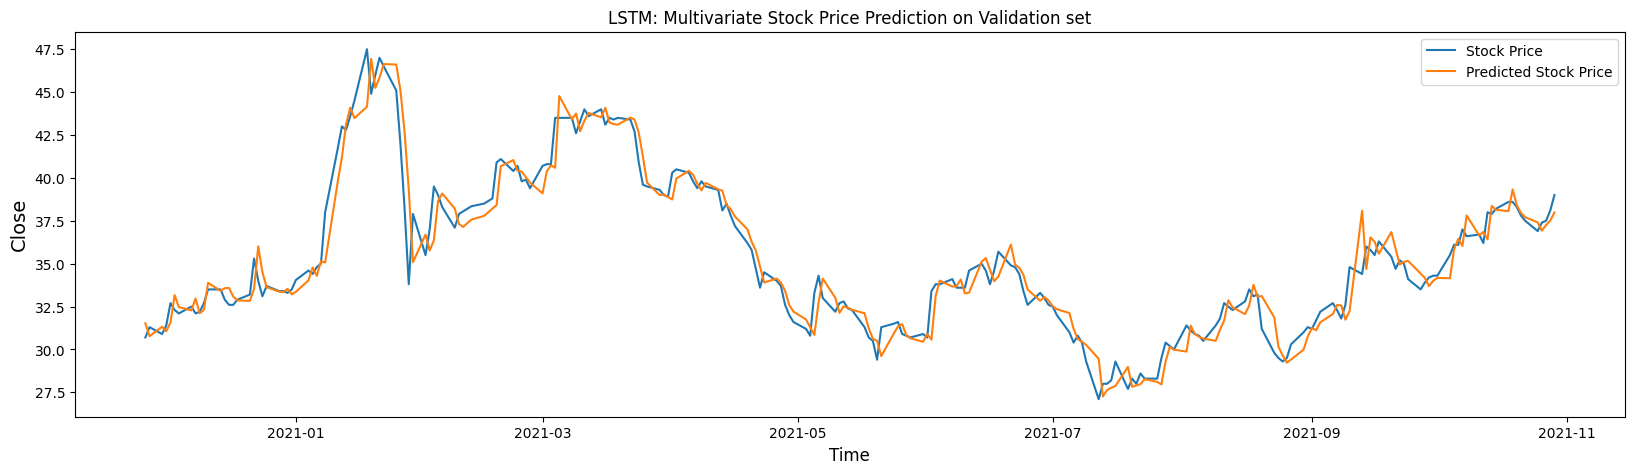

In [44]:
plt.figure(figsize=(20, 5))
plt.plot(real_validation_df['close'], label='Stock Price')
plt.plot(predictions_validation_df['close'], label='Predicted Stock Price')
plt.title('LSTM: Multivariate Stock Price Prediction on Validation set')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

In [45]:
# Now the loaded model is ready for prediction
predictions_training = loaded_model.predict(yuan_X_train)
predictions_training  = yuan_sc.inverse_transform(predictions_training)
predictions_training_list = np.array(predictions_training[:, 0]).flatten().tolist() # 0 means close predicted value

real_training = yuan_sc.inverse_transform(yuan_y_train)
real_training_list = np.array(real_training[:, 0]).flatten().tolist()


# evaluation_metric(y_test,y_hat):
evaluation_metric(real_training_list, predictions_training_list)

# n_timestamp = 10, Bi
# MSE: 0.64162
# RMSE: 0.80101
# MAE: 0.54540
# R2: 0.97756

# n_timestamp = 1, Bi
# MSE: 0.70603
# RMSE: 0.84026
# MAE: 0.56705
# R2: 0.97494

# n_timestamp = 1, SL
# MSE: 0.73736
# RMSE: 0.85870
# MAE: 0.58630
# R2: 0.97383

# n_timestamp = 1, SL, 128, dropout 0.2
# MSE: 0.84403
# RMSE: 0.91871
# MAE: 0.66525
# R2: 0.97004

# n_timestamp = 1, ML
# MSE: 0.76081
# RMSE: 0.87225
# MAE: 0.61322
# R2: 0.97300

MSE: 0.80627
RMSE: 0.89792
MAE: 0.62360
R2: 0.97138


In [46]:
# GetMAPE(y_hat, y_test):
mape_LSTM_training = GetMAPE(np.array(predictions_training_list), np.array(real_training_list))
print('mape_LSTM_training : %.3f' % mape_LSTM_training, '%' )
# n_timestamp = 10, Bi
# mape_LSTM_training : 2.198 %

# n_timestamp = 1, Bi
# mape_LSTM_training : 2.282 %

# n_timestamp = 1, SL
# mape_LSTM_training : 2.351 %

# n_timestamp = 1, SL, 128, dropout 0.2
# mape_LSTM_training : 2.918 %

# n_timestamp = 1, ML
# mape_LSTM_training : 2.441 %

mape_LSTM_training : 2.564 %


In [48]:
predictions_training_df = {
    'date': yuan_train.index[1:], # Passing first 1 time step
    'close': predictions_training_list
}
predictions_training_df = pd.DataFrame(predictions_training_df)
predictions_training_df = predictions_training_df.set_index(['date'], drop=True)


real_training_df = {
    'date': yuan_train.index[1:],
    'close': real_training_list
}
real_training_df = pd.DataFrame(real_training_df)
real_training_df = real_training_df.set_index(['date'], drop=True)

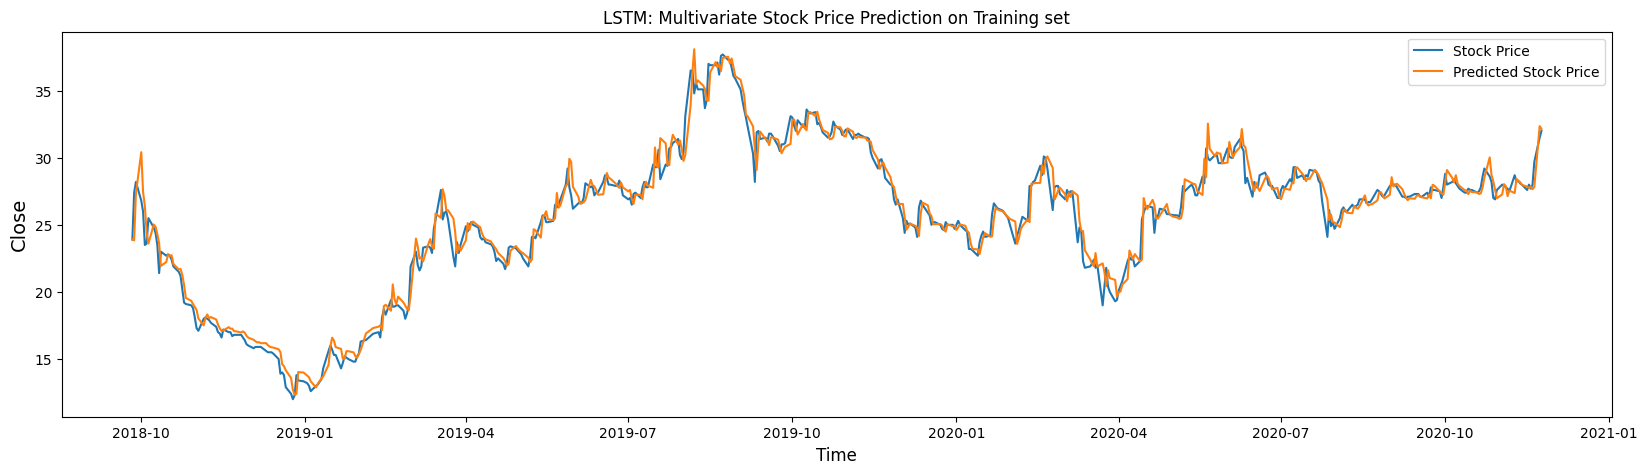

In [49]:
plt.figure(figsize=(20, 5))
plt.plot(real_training_df['close'], label='Stock Price')
plt.plot(predictions_training_df['close'], label='Predicted Stock Price')
plt.title('LSTM: Multivariate Stock Price Prediction on Training set')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()